In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass
%matplotlib inline

### View original image

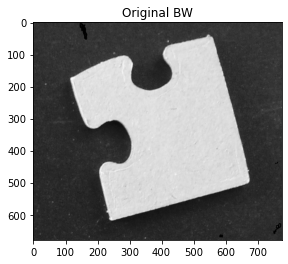

In [2]:
filename = "02.JPG"
puzzles = cv2.imread(filename)
puzzles = cv2.cvtColor(puzzles, cv2.COLOR_BGR2GRAY)
plt.imshow(puzzles, cmap='gray'); plt.title("Original BW"); plt.show()

In [3]:
puzzles.shape 

(679, 775)

### View blurred image | threshold

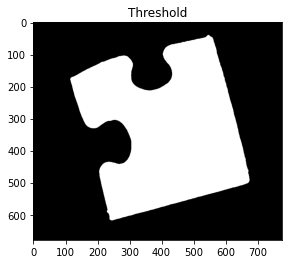

In [4]:
blurred = cv2.blur(puzzles, (7,7))
best = cv2.threshold(blurred, 140, 255, type=cv2.THRESH_BINARY)[1]
plt.imshow(best, cmap='gray'); plt.title("Threshold"); plt.show()
contours, hierarchy = cv2.findContours(best, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

### Find contours

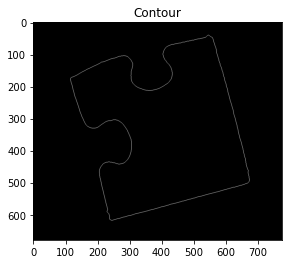

In [5]:
dst_norm = np.empty(puzzles.shape, dtype=np.float32)
cv2.drawContours(dst_norm, contours, -1, (255,0,0), 1)
plt.imshow(dst_norm, cmap='gray'); plt.title("Contour"); plt.show()

In [6]:
print(type(contours), len(contours))

<class 'tuple'> 1


### Find Centroid

In [7]:
Xs, Ys = [], []
for point in contours[0]:
    Ys.append (point[0, 0])
    Xs.append(point[0, 1])

centroid = (int(sum(Ys) / len(Ys)), int(sum(Xs) / len(Xs)))
centroid

(382, 314)

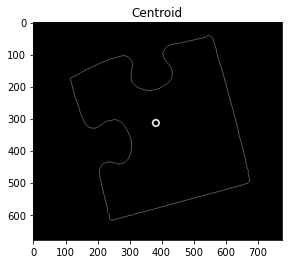

In [8]:
cv2.circle(dst_norm, centroid, 10, (255), 3)
plt.imshow(dst_norm, cmap='gray'); plt.title("Centroid"); plt.show()

### Find distance of contour points to centroid

In [9]:
def calc_dist(point_A, point_B):
    '''
    Calculates the distance between two points
    parameters:: Point_A

    returns:: the distance (float)
    '''
    a_y = point_A[0]
    a_x = point_A[1]
    b_y = point_B[0]
    b_x = point_B[1]
    dist = ((a_y - b_y) ** 2) + ((a_x - b_x) ** 2)
    return math.sqrt(dist)

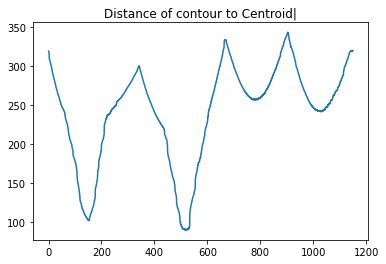

In [15]:
distances = []
for point in contours[0]:
    distances.append(calc_dist(point[0], centroid))
plt.plot(distances); plt.title("Distance of contour to Centroid"); plt.show(); plt.close()

### Find peaks in the diagram above

In [11]:
def find_peaks_idx(distances, num_peaks, duplicate_radius=10):
    '''
    Takes a 1D array, and finds the peaks.
    parameters:
    distances: a 1D array, in the form of a list. Each element includes an elevation (float)
    num_peaks: integer, number of peaks to return
    duplicate_radius: integer to determine whether two points are duplicate or not

    returns:
    peaks_id: a list of length 'num_peaks'
    '''
    peaks_idx = []
    ids_to_remove = []
    length = len(distances)
    for idx, point in enumerate(distances):
        neighbor_l_1 = (idx - 1) % length
        neighbor_r_1 = (idx + 1) % length
        neighbor_l_2 = (idx - 5) % length
        neighbor_r_2 = (idx + 5) % length
        if distances[neighbor_l_2] <= distances[neighbor_l_1] <= point  >= distances[neighbor_r_1] >= distances[neighbor_r_2]:
            for existing_point, existing_idx in peaks_idx:
                if abs(idx - existing_idx) < duplicate_radius:
                    ids_to_remove.append(idx)
                    
            if idx not in ids_to_remove:
                peaks_idx.append((point,idx))
    
    peaks_idx = sorted(peaks_idx)[::-1]
    return peaks_idx[0:num_peaks]

In [12]:
peaks = find_peaks_idx(distances=distances, num_peaks=400)
peaks

[(342.9125252888847, 904),
 (333.24165405903267, 666),
 (319.2397218392473, 1142),
 (299.7081914129142, 341)]

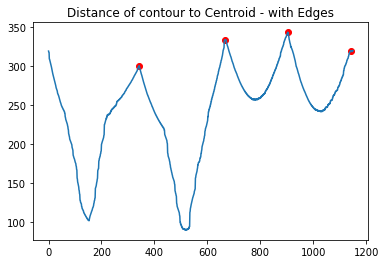

In [13]:
distances = []
for point in contours[0]:
    distances.append(calc_dist(point[0], centroid))
plt.plot(distances); plt.scatter(([idx for _,idx in peaks]), ([alt for alt,_ in peaks]), color="red")
plt.title("Distance of contour to Centroid - with Edges"); plt.show()

### Find edges of the Jigsaw piece

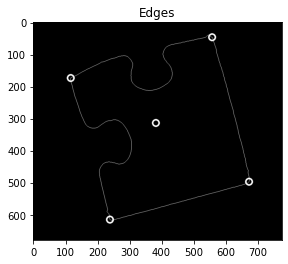

In [17]:
dst_norm2 = dst_norm
for dist, idx in peaks:
    edge = contours[0][idx][0]
    edge_y = edge[0]
    edge_x = edge[1]
    cv2.circle(dst_norm2, (edge_y, edge_x), 10, (255, 0, 0), 3)

plt.imshow(dst_norm2, cmap='gray'); plt.title("Edges"); plt.show()
plt.imsave("out.png", dst_norm2, cmap='gray')

### Find straight lines

In [25]:
@dataclass
class Edge:
    id: int
    y: int
    x: int
    distances = {}
    neighbors = []

    def dist(self, other_edge):
        diff_x = (self.x - other_edge.x) ** 2
        diff_y = (self.y - other_edge.y) ** 2
        return math.sqrt(diff_x + diff_y)
    
    def find_distance(self, edge):
        self.distances[edge.id] = self.dist(edge)

    def find_neighbors(self):
        

In [32]:
edges_list = []
for edge_id, (dist, idx) in enumerate(peaks):
    edge = contours[0][idx][0]
    edge_y = edge[0]
    edge_x = edge[1]
    edges_list.append(Edge(edge_id, edge_y, edge_x))

for edge in edges_list:
    for sub_edge in edges_list:
        edge.find_distance(sub_edge)

In [42]:
val_temp = max(edges_list[2].distances.values())